In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
class ResNet18Regressor(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Regressor, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.resnet(x)
        return out

In [3]:

import os, math
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CircleRadiusDataset(Dataset):
    def __init__(self, image_dir, csv_file,  means = [0], stds = [1], test=False):
        # In test mode, we need to use the mean and standard deviation computed from the training set
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.means = []
        self.stds = []
        if not test:
            for col in self.df.columns[1:]:
                self.means.append(self.df[col].mean())
                self.stds.append(self.df[col].std())
                self.df[col] = (self.df[col] - self.means[-1]) / self.stds[-1]
                self.df[col] = self.df[col].astype('float32')
            print (self.means)
            print (self.stds)
        else:
            for i, col in enumerate(self.df.columns[1:]):
                self.df[col] = (self.df[col] - means[i]) / stds[i]
                self.df[col] = self.df[col].astype('float32')            
            
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        xs = self.df.iloc[idx, 1:len(self.df.columns)].values
        
        # The transform below is required by Resnet 18
        preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
        input_tensor = preprocess(image)
        #input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

        return input_tensor, torch.from_numpy(np.array(xs, dtype=np.float32))


In [4]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

def train(model, dataset, testset, batch_size, num_epochs, learning_rate):
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print("Epoch [{}/{}], Loss: {:.8f}".format(epoch+1, num_epochs, epoch_loss))
                    
        
        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
            test_loss /= len(test_loader)
            print ('   Test loss:', test_loss)
            
            model.train()



Device: cuda


In [5]:
train_dataset = CircleRadiusDataset(image_dir="./arrowed_train", csv_file="./ArrowInfo_train.csv")
test_dataset = CircleRadiusDataset(image_dir="./arrowed_test", csv_file="./ArrowInfo_test.csv",
                                   means = train_dataset.means, 
                                   stds = train_dataset.stds,
                                   test=True)

model = ResNet18Regressor(num_classes=5)

[14.998477309521844, 111.02903208428097, 111.92615894788703, 0.004743178609792218, 0.0051306632839993585]
[2.395358926446069, 52.54662315834066, 52.60121424409957, 0.7050827517511564, 0.7091611219266939]


/home/pcfu/anaconda3/envs/torch_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pcfu/anaconda3/envs/torch_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Manually reduce learning rate to get more precise.
train(model, train_dataset, test_dataset, 1, 4, 0.5e-4)

Epoch [1/4], Loss: 0.32729692
   Test loss: 4.7799750631451605
Epoch [2/4], Loss: 0.03024142
   Test loss: 4.252317183494568
Epoch [3/4], Loss: 0.01907823
   Test loss: 13.013816215097904
Epoch [4/4], Loss: 0.01376904
   Test loss: 8.102222621381284


In [7]:
train(model, train_dataset, test_dataset, 1, 3, 0.2e-4)

Epoch [1/3], Loss: 0.00591374
   Test loss: 8.157962574064731
Epoch [2/3], Loss: 0.00390188
   Test loss: 5.213220836296678
Epoch [3/3], Loss: 0.00300103
   Test loss: 8.566845029979945


In [18]:
train(model, train_dataset, test_dataset, 1, 1, 0.1e-4)

Epoch [1/1], Loss: 0.00192394
   Test loss: 5.105588290512562


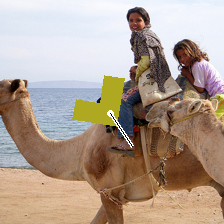

In [16]:
# Single image validation
import random
i = random.randint(0, 1000)

img_tensor, x = test_dataset.__getitem__(i)
input_tensor = img_tensor.to(device)
outputs = model(input_tensor.unsqueeze(0))

image = Image.open('arrowed_test/arrowed_' + str(i).zfill(4) + '.png').convert("RGB")
s, cx, cy, cos, sin = (outputs.cpu().detach().numpy() * train_dataset.stds + train_dataset.means)[0]


draw = ImageDraw.Draw(image)
draw.ellipse((cx-3,cy-3,cx+3,cy+3),  'white')
draw.line((cx,cy,cx+cos*s*2,cy+sin*s*2),  width = 3, fill='white')
draw.line((cx,cy,cx+cos*s*2,cy+sin*s*2),  width = 1, fill='black')
display(image)

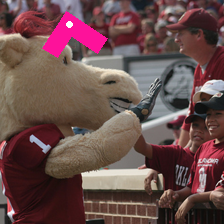

In [38]:
# Drawing ground truth
_, x = test_dataset.__getitem__(i)

s, cx, cy, cos, sin = x.cpu().detach().numpy() * train_dataset.stds + train_dataset.means
image = Image.open('arrowed_test/arrowed_' + str(i).zfill(4) + '.png').convert("RGB")

draw = ImageDraw.Draw(image)
draw.ellipse((cx-3,cy-3,cx+3,cy+3),  'white')
# draw.line((cx,cy,cx+cos*s*2,cy+sin*s*2),  width = 3, fill='white')
# draw.line((cx,cy,cx+cos*s*2,cy+sin*s*2),  width = 1, fill='black')
display(image)

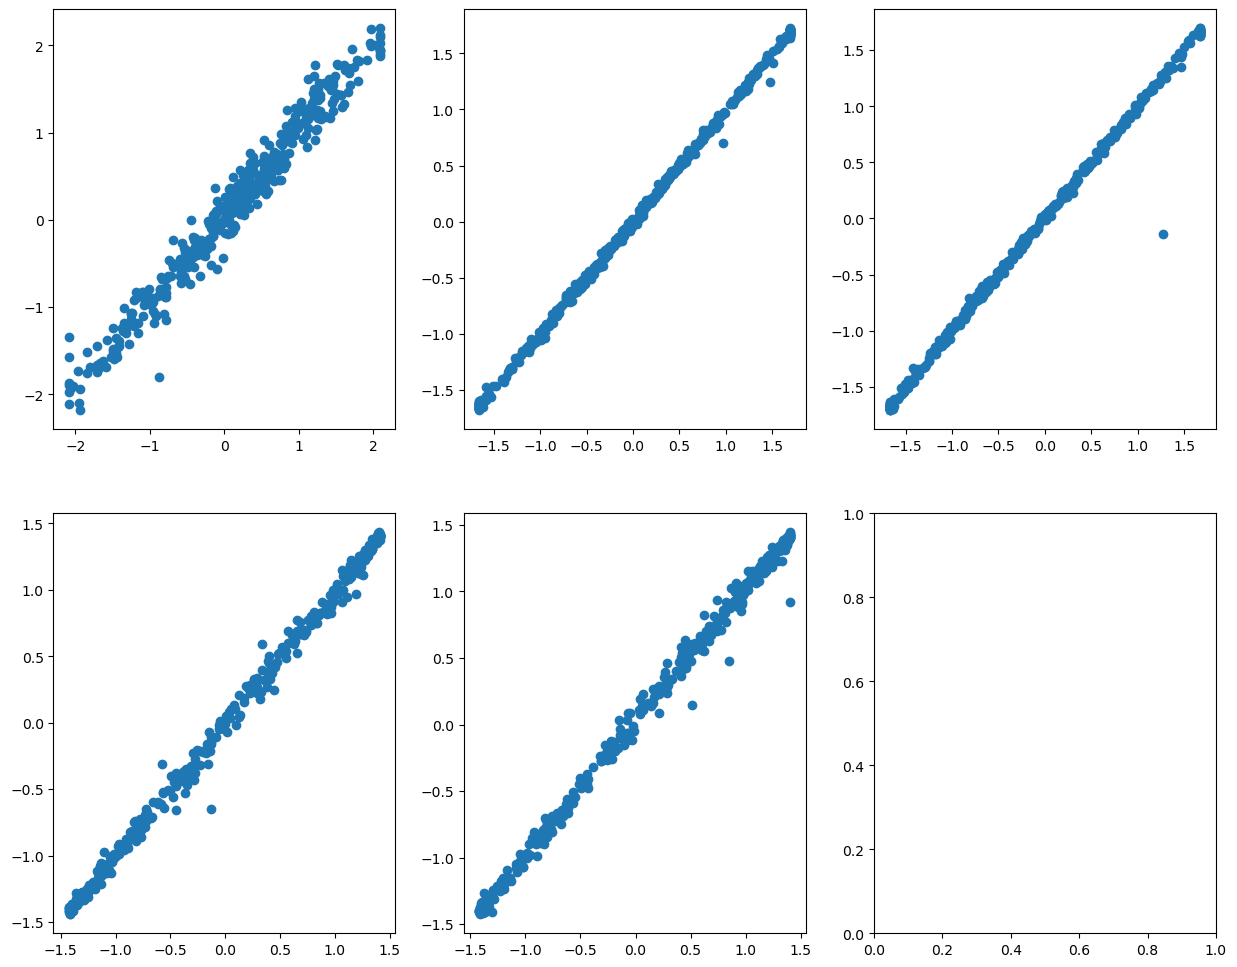

In [17]:
# batch test

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
count = 0
xs = [[],[],[],[], []]
ys = [[],[],[],[], []]

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    for x, v in zip(xs, labels.cpu().numpy()[0]):
        x.append(v)
    for y, v in zip(ys, outputs.cpu().detach().numpy()[0]):
        y.append(v)

    count += 1
    if count > 400:
        break
fig, ax = plt.subplots(2,3, figsize=(15,12))
for i in range(5):
    p = i // 3
    q = i % 3
    ax[p][q].scatter(xs[i], ys[i])